# 📊 Evaluate Models and Visualize Results

**Objective:** Evaluate trained models on test set and compare results

**Models:**
- Model 1: Spatial Context CNN
- Model 2: Multi-Scale CNN
- Model 3: Shallow U-Net

**Tasks:**
- Load trained models from checkpoints
- Evaluate on test set
- Generate confusion matrices
- Plot ROC curves
- Visualize sample predictions
- Compare model outputs
- Create summary report

**Expected time:** 5-10 minutes

## 1. Setup Python Path and Imports

In [1]:
import sys
from pathlib import Path

# Add project root and src to Python path
project_root = Path.cwd().parent
src_path = project_root / 'src'

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print("✅ Python path configured:")
print(f"   Project root: {project_root}")
print(f"   Source dir: {src_path}")

# Now import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, roc_auc_score
)
import warnings
warnings.filterwarnings('ignore')

# Import from src
from src.dataset import DeforestationDataset
from src.models import get_model, count_parameters

print("\n✅ Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

✅ Python path configured:
   Project root: d:\HaiDang\25-26_HKI_DATN_21021411_DangNH
   Source dir: d:\HaiDang\25-26_HKI_DATN_21021411_DangNH\src

✅ Libraries imported successfully!
PyTorch version: 1.13.1+cu117
CUDA available: True
CUDA device: NVIDIA RTX A4000


## 2. Configuration

In [2]:
# Paths
PATCHES_DIR = Path('../data/patches')
CHECKPOINTS_DIR = Path('../checkpoints')
FIGURES_DIR = Path('../figures')
OUTPUTS_DIR = Path('../outputs')

# Create directories
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
(FIGURES_DIR / 'confusion_matrices').mkdir(exist_ok=True)
(FIGURES_DIR / 'sample_predictions').mkdir(exist_ok=True)
OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)

# Config
CONFIG = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'batch_size': 16,
    'num_workers': 4
}

# Model info
MODEL_INFO = {
    'spatial_cnn': {
        'name': 'Spatial Context CNN',
        'checkpoint': CHECKPOINTS_DIR / 'spatial_cnn_best.pth',
        'color': '#1f77b4'
    },
    'multiscale_cnn': {
        'name': 'Multi-Scale CNN',
        'checkpoint': CHECKPOINTS_DIR / 'multiscale_cnn_best.pth',
        'color': '#ff7f0e'
    },
    'shallow_unet': {
        'name': 'Shallow U-Net',
        'checkpoint': CHECKPOINTS_DIR / 'shallow_unet_best.pth',
        'color': '#2ca02c'
    }
}

print("\n📋 Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")


📋 Configuration:
  device: cuda
  batch_size: 16
  num_workers: 4


## 3. Load Test Dataset

In [3]:
print("📊 Loading test dataset...\n")

test_dataset = DeforestationDataset(
    patches_dir=str(PATCHES_DIR / 'test'),
    augment=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

print(f"Test set: {len(test_dataset)} samples")
print(f"Batches: {len(test_loader)}")
print(f"\nClass distribution:")
print(f"  Class 0 (No deforestation): {test_dataset.class_counts[0]}")
print(f"  Class 1 (Deforestation): {test_dataset.class_counts[1]}")

📊 Loading test dataset...

✅ Dataset loaded: 193 patches
   Class 0 (No deforestation): 98
   Class 1 (Deforestation): 95
Test set: 193 samples
Batches: 13

Class distribution:
  Class 0 (No deforestation): 98
  Class 1 (Deforestation): 95


## 4. Load Trained Models

In [4]:
print("\n📦 Loading trained models...\n")

models = {}
for model_key, info in MODEL_INFO.items():
    checkpoint_path = info['checkpoint']
    
    if not checkpoint_path.exists():
        print(f"❌ Checkpoint not found: {checkpoint_path}")
        print(f"   Please run notebook 03_train_models.ipynb first.")
        continue
    
    # Load model
    model = get_model(model_key, in_channels=18)
    checkpoint = torch.load(checkpoint_path, map_location=CONFIG['device'])
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(CONFIG['device'])
    model.eval()
    
    models[model_key] = model
    
    print(f"✅ Loaded: {info['name']}")
    print(f"   Checkpoint: {checkpoint_path.name}")
    print(f"   Epoch: {checkpoint['epoch']}")
    print(f"   Val Loss: {checkpoint['val_loss']:.4f}")
    print(f"   Val Acc: {checkpoint['val_acc']*100:.2f}%")
    print(f"   Parameters: {count_parameters(model):,}\n")

if not models:
    raise FileNotFoundError("No model checkpoints found. Please train models first.")


📦 Loading trained models...

✅ Loaded: Spatial Context CNN
   Checkpoint: spatial_cnn_best.pth
   Epoch: 37
   Val Loss: 0.3376
   Val Acc: 85.49%
   Parameters: 14,625

✅ Loaded: Multi-Scale CNN
   Checkpoint: multiscale_cnn_best.pth
   Epoch: 20
   Val Loss: 0.3304
   Val Acc: 85.49%
   Parameters: 93,953

✅ Loaded: Shallow U-Net
   Checkpoint: shallow_unet_best.pth
   Epoch: 52
   Val Loss: 0.2332
   Val Acc: 91.71%
   Parameters: 477,153



## 5. Evaluate Models on Test Set

In [5]:
def evaluate_model(model, dataloader, device):
    """
    Evaluate model on test set
    
    Returns:
        y_true: Ground truth labels
        y_pred: Predicted labels (0 or 1)
        y_proba: Predicted probabilities [0, 1]
    """
    model.eval()
    
    all_labels = []
    all_preds = []
    all_probas = []
    
    with torch.no_grad():
        for patches, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            patches = patches.to(device)
            labels = labels.cpu().numpy()
            
            # Forward pass
            outputs = model(patches)  # (B, 1, H, W)
            outputs_pooled = outputs.mean(dim=[2, 3])  # (B, 1)
            
            probas = outputs_pooled.cpu().numpy().flatten()
            preds = (probas > 0.5).astype(int)
            
            all_labels.extend(labels)
            all_preds.extend(preds)
            all_probas.extend(probas)
    
    return np.array(all_labels), np.array(all_preds), np.array(all_probas)


print("\n" + "="*80)
print("EVALUATING MODELS ON TEST SET")
print("="*80 + "\n")

results = {}
for model_key, model in models.items():
    print(f"Evaluating {MODEL_INFO[model_key]['name']}...")
    
    y_true, y_pred, y_proba = evaluate_model(
        model, test_loader, CONFIG['device']
    )
    
    results[model_key] = {
        'y_true': y_true,
        'y_pred': y_pred,
        'y_proba': y_proba
    }
    
    print(f"  ✅ Complete: {len(y_true)} samples evaluated\n")


EVALUATING MODELS ON TEST SET

Evaluating Spatial Context CNN...


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

  ✅ Complete: 193 samples evaluated

Evaluating Multi-Scale CNN...


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

  ✅ Complete: 193 samples evaluated

Evaluating Shallow U-Net...


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

  ✅ Complete: 193 samples evaluated



## 6. Calculate Metrics

In [6]:
print("\n" + "="*80)
print("TEST SET METRICS")
print("="*80 + "\n")

metrics_data = []

for model_key in models.keys():
    y_true = results[model_key]['y_true']
    y_pred = results[model_key]['y_pred']
    y_proba = results[model_key]['y_proba']
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_proba)
    
    metrics_data.append({
        'Model': MODEL_INFO[model_key]['name'],
        'Accuracy': f"{accuracy*100:.2f}%",
        'Precision': f"{precision*100:.2f}%",
        'Recall': f"{recall*100:.2f}%",
        'F1-Score': f"{f1*100:.2f}%",
        'AUC-ROC': f"{roc_auc:.4f}"
    })
    
    print(f"{MODEL_INFO[model_key]['name']}:")
    print(f"  Accuracy:  {accuracy*100:.2f}%")
    print(f"  Precision: {precision*100:.2f}%")
    print(f"  Recall:    {recall*100:.2f}%")
    print(f"  F1-Score:  {f1*100:.2f}%")
    print(f"  AUC-ROC:   {roc_auc:.4f}\n")

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)
print("\n" + "="*80)
print(metrics_df.to_string(index=False))
print("="*80)

# Save metrics
metrics_path = OUTPUTS_DIR / 'test_metrics.csv'
metrics_df.to_csv(metrics_path, index=False)
print(f"\n✅ Saved metrics: {metrics_path}")


TEST SET METRICS

Spatial Context CNN:
  Accuracy:  85.49%
  Precision: 90.36%
  Recall:    78.95%
  F1-Score:  84.27%
  AUC-ROC:   0.9265

Multi-Scale CNN:
  Accuracy:  83.42%
  Precision: 88.89%
  Recall:    75.79%
  F1-Score:  81.82%
  AUC-ROC:   0.9277

Shallow U-Net:
  Accuracy:  89.64%
  Precision: 91.21%
  Recall:    87.37%
  F1-Score:  89.25%
  AUC-ROC:   0.9605


              Model Accuracy Precision Recall F1-Score AUC-ROC
Spatial Context CNN   85.49%    90.36% 78.95%   84.27%  0.9265
    Multi-Scale CNN   83.42%    88.89% 75.79%   81.82%  0.9277
      Shallow U-Net   89.64%    91.21% 87.37%   89.25%  0.9605

✅ Saved metrics: ..\outputs\test_metrics.csv


## 7. Confusion Matrices


📊 Generating confusion matrices...

✅ Saved: ..\figures\confusion_matrices\confusion_matrices_all_models.png


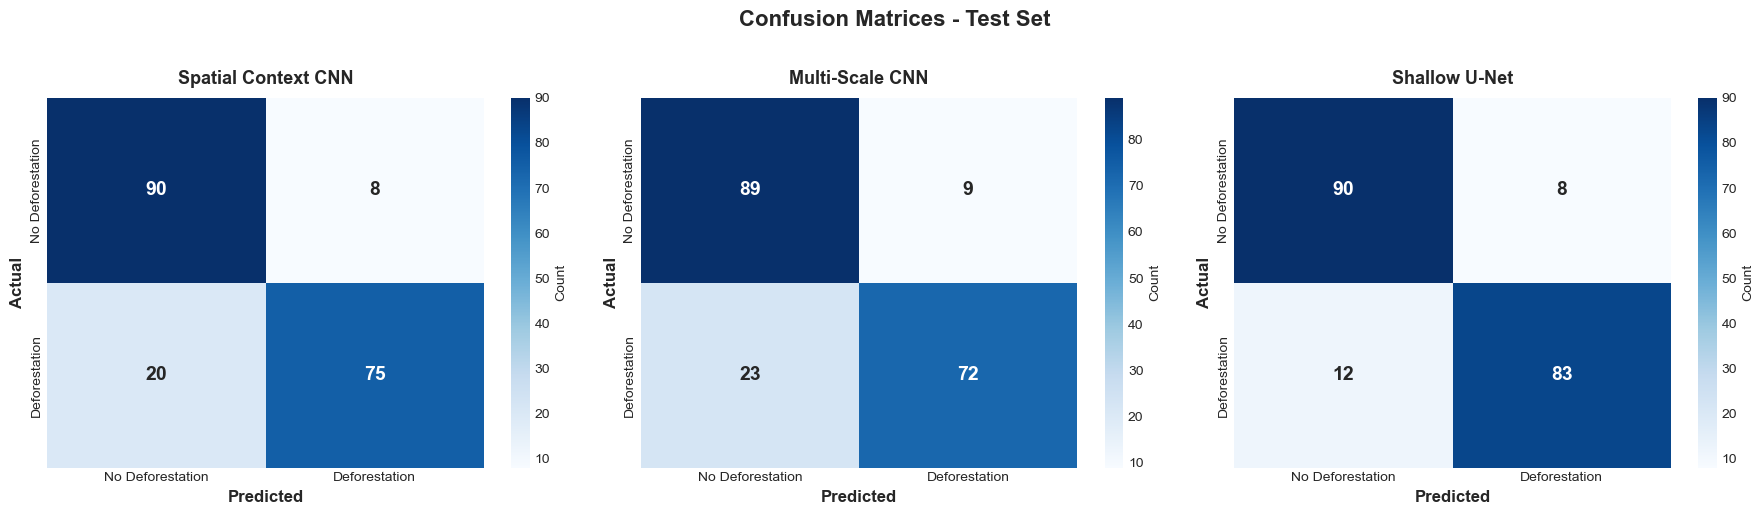

In [7]:
print("\n📊 Generating confusion matrices...\n")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices - Test Set', fontsize=16, fontweight='bold', y=1.02)

for idx, (model_key, ax) in enumerate(zip(models.keys(), axes.flat)):
    y_true = results[model_key]['y_true']
    y_pred = results[model_key]['y_pred']
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=['No Deforestation', 'Deforestation'],
        yticklabels=['No Deforestation', 'Deforestation'],
        ax=ax, cbar_kws={'label': 'Count'},
        annot_kws={'fontsize': 14, 'fontweight': 'bold'}
    )
    
    ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
    ax.set_title(MODEL_INFO[model_key]['name'], fontsize=13, fontweight='bold', pad=10)

plt.tight_layout()
save_path = FIGURES_DIR / 'confusion_matrices' / 'confusion_matrices_all_models.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✅ Saved: {save_path}")
plt.show()

## 8. ROC Curves


📈 Plotting ROC curves...

✅ Saved: ..\figures\roc_curves_all_models.png


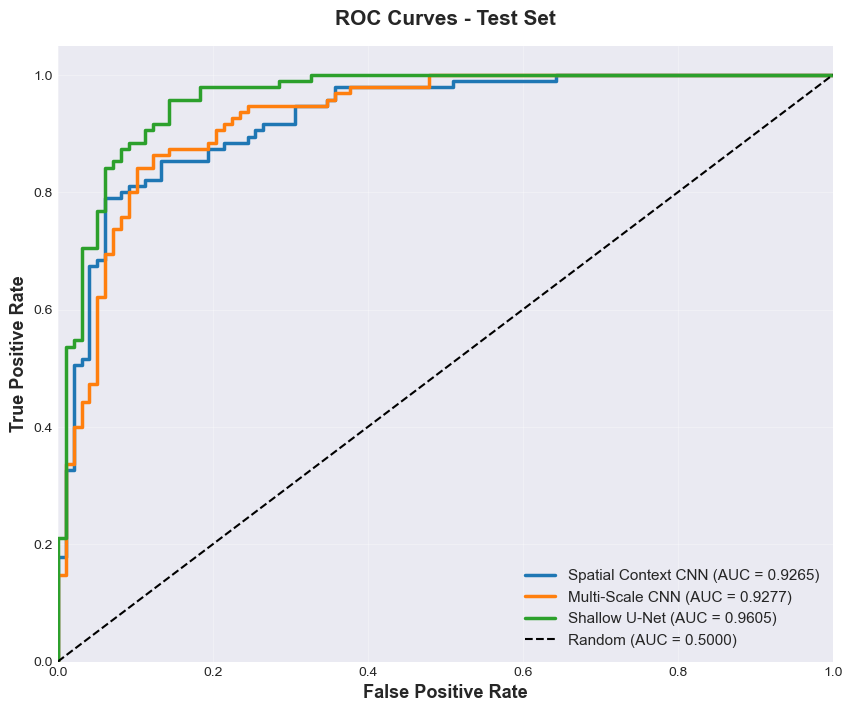

In [8]:
print("\n📈 Plotting ROC curves...\n")

plt.figure(figsize=(10, 8))

for model_key in models.keys():
    y_true = results[model_key]['y_true']
    y_proba = results[model_key]['y_proba']
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.plot(
        fpr, tpr,
        label=f"{MODEL_INFO[model_key]['name']} (AUC = {roc_auc:.4f})",
        color=MODEL_INFO[model_key]['color'],
        linewidth=2.5
    )

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random (AUC = 0.5000)')

plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('ROC Curves - Test Set', fontsize=15, fontweight='bold', pad=15)
plt.legend(loc='lower right', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

save_path = FIGURES_DIR / 'roc_curves_all_models.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✅ Saved: {save_path}")
plt.show()

## 9. Detailed Classification Reports

In [9]:
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORTS")
print("="*80 + "\n")

for model_key in models.keys():
    y_true = results[model_key]['y_true']
    y_pred = results[model_key]['y_pred']
    
    print(f"{MODEL_INFO[model_key]['name']}:")
    print("-" * 80)
    report = classification_report(
        y_true, y_pred,
        target_names=['No Deforestation', 'Deforestation'],
        digits=4
    )
    print(report)
    print()


DETAILED CLASSIFICATION REPORTS

Spatial Context CNN:
--------------------------------------------------------------------------------
                  precision    recall  f1-score   support

No Deforestation     0.8182    0.9184    0.8654        98
   Deforestation     0.9036    0.7895    0.8427        95

        accuracy                         0.8549       193
       macro avg     0.8609    0.8539    0.8540       193
    weighted avg     0.8602    0.8549    0.8542       193


Multi-Scale CNN:
--------------------------------------------------------------------------------
                  precision    recall  f1-score   support

No Deforestation     0.7946    0.9082    0.8476        98
   Deforestation     0.8889    0.7579    0.8182        95

        accuracy                         0.8342       193
       macro avg     0.8418    0.8330    0.8329       193
    weighted avg     0.8410    0.8342    0.8331       193


Shallow U-Net:
-----------------------------------------------

## 10. Visualize Sample Predictions


📸 Visualizing sample predictions...

✅ Saved: ..\figures\sample_predictions\sample_predictions_comparison.png


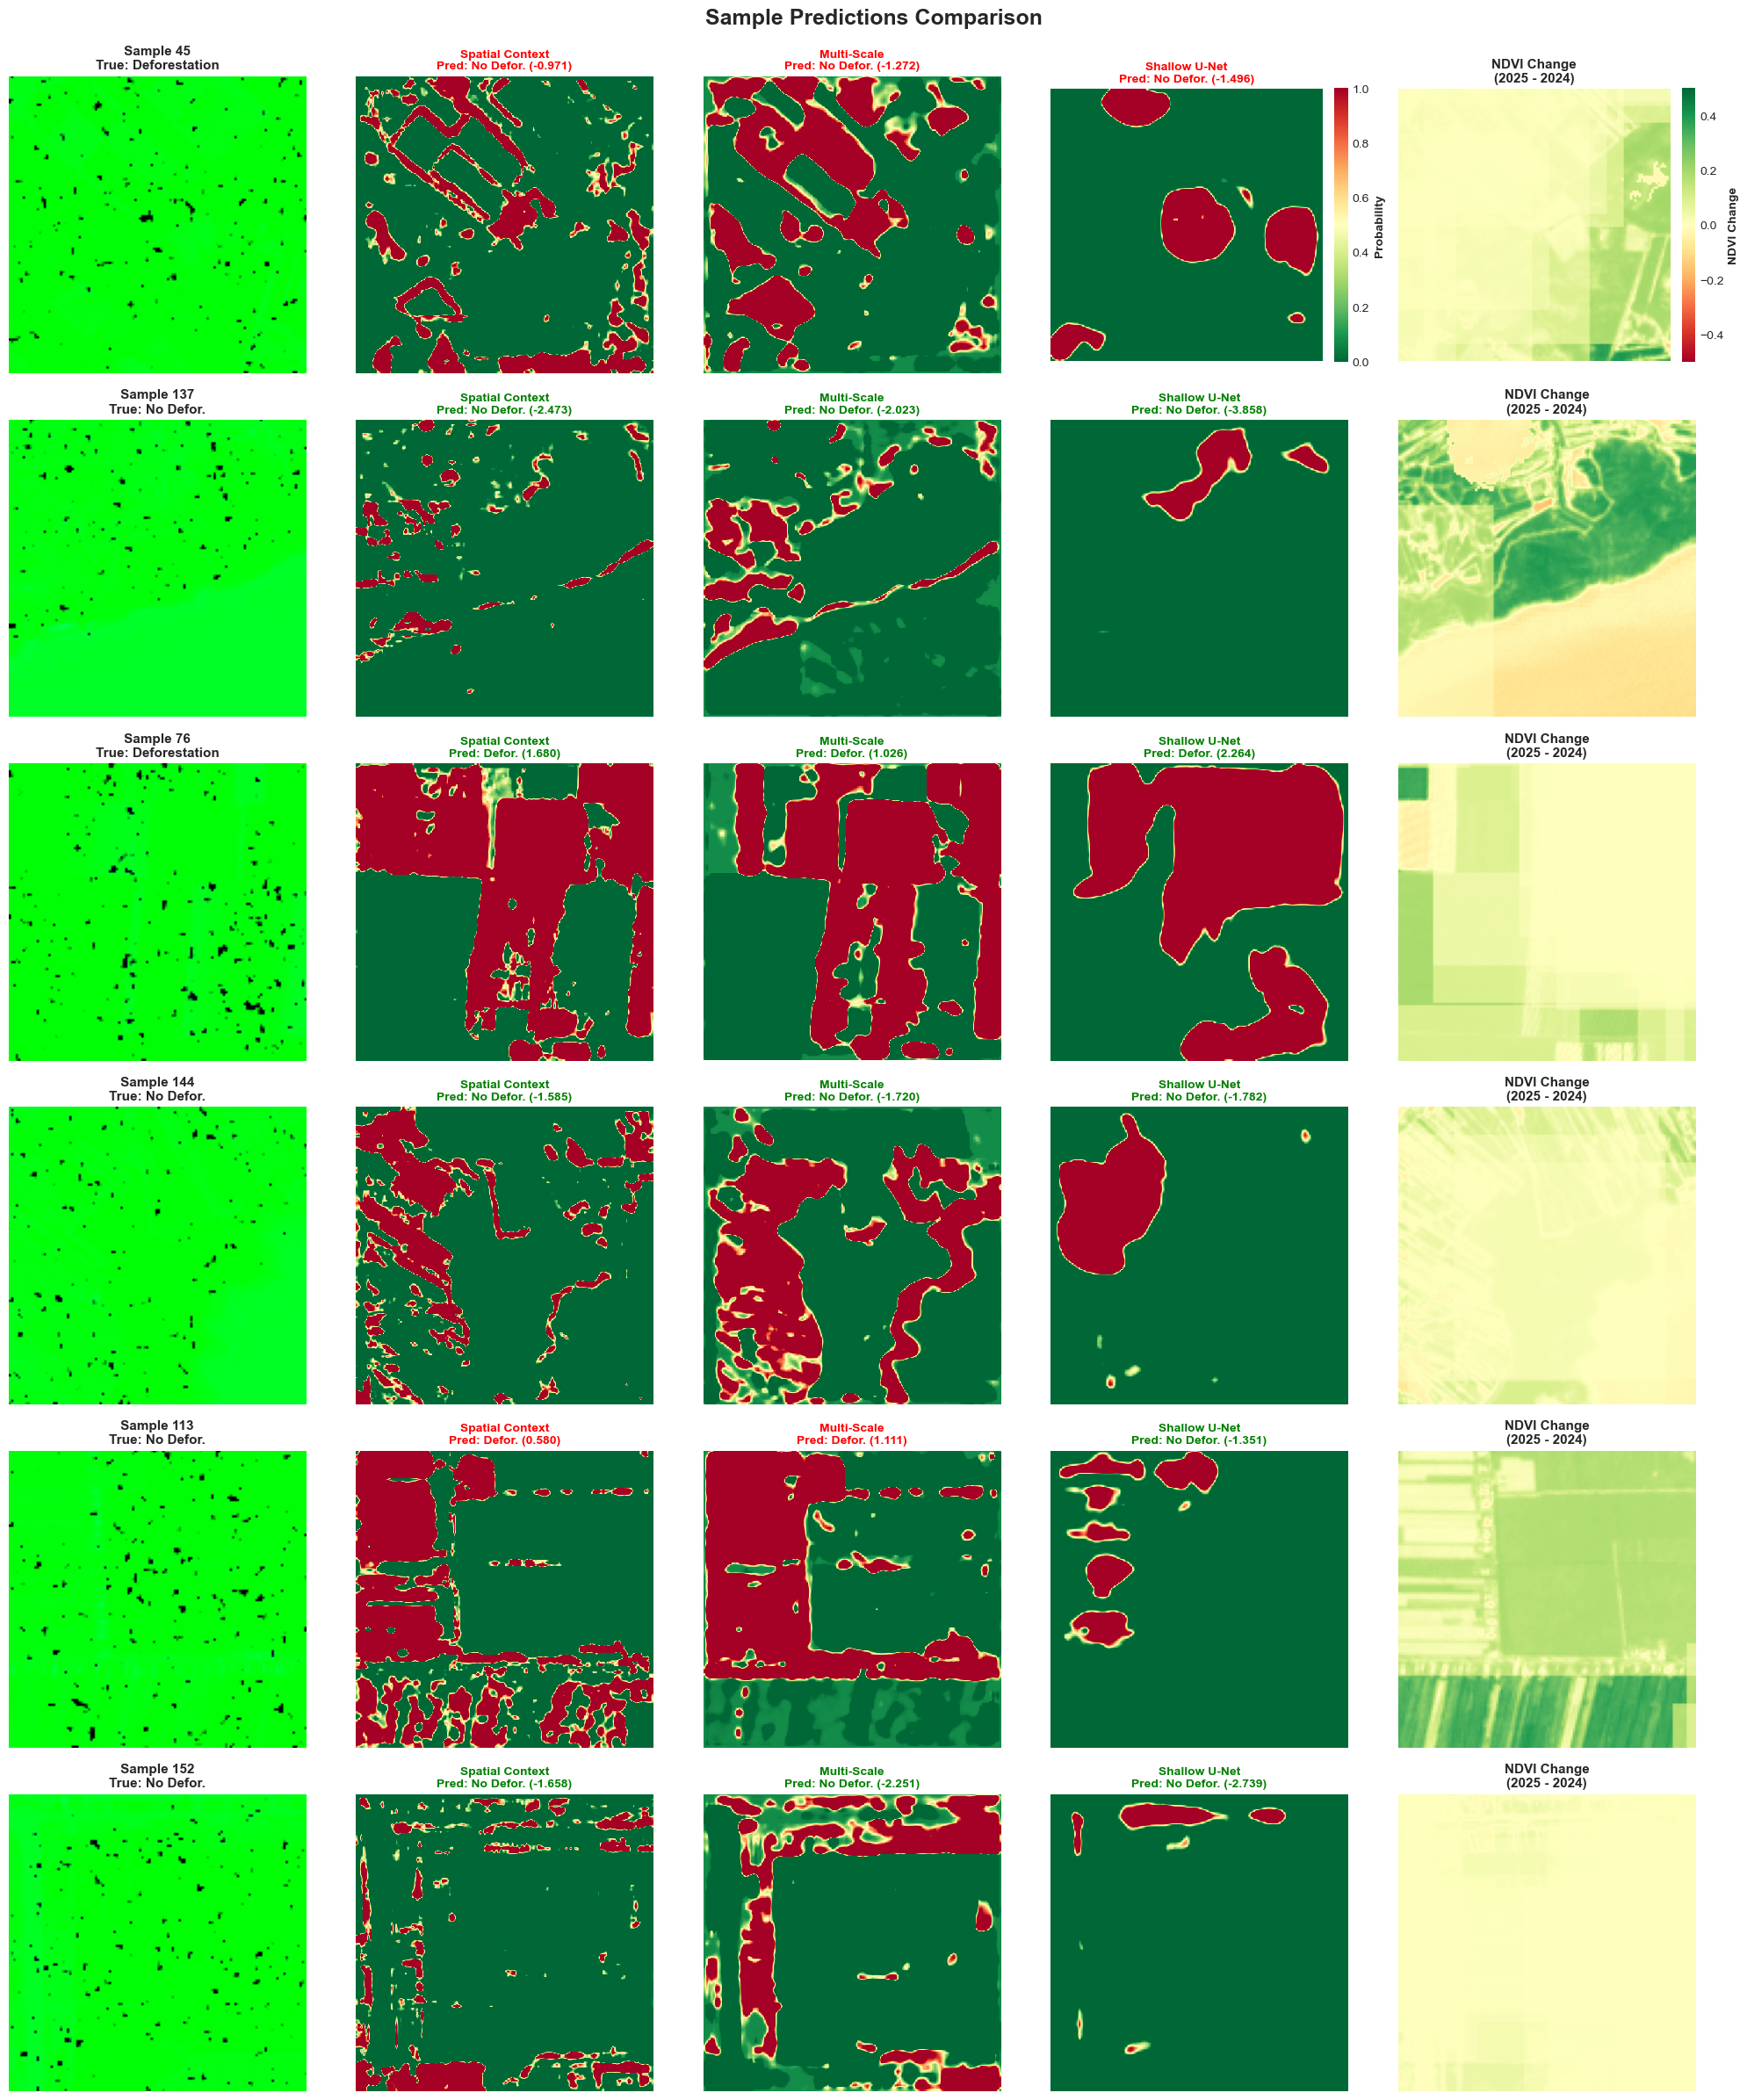

In [10]:
print("\n📸 Visualizing sample predictions...\n")

def visualize_predictions(test_dataset, models, results, num_samples=6):
    """
    Visualize predictions for random samples
    """
    # Select random samples
    np.random.seed(42)
    indices = np.random.choice(len(test_dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))
    fig.suptitle('Sample Predictions Comparison', fontsize=18, fontweight='bold', y=0.995)
    
    for row, idx in enumerate(indices):
        patch, label = test_dataset[idx]
        patch_np = patch.numpy()  # (18, 128, 128)
        
        # Get RGB composite (using S2 bands: R=B4, G=B8, B=B11)
        # Indices: B4=2, B8=3, B11=4 (2024)
        rgb = np.stack([
            patch_np[2],   # Red
            patch_np[3],   # NIR (as Green)
            patch_np[4]    # SWIR1 (as Blue)
        ], axis=-1)
        
        # Normalize to [0, 1] for display
        rgb = np.clip(rgb, 0, 1)
        
        # Column 0: RGB composite
        axes[row, 0].imshow(rgb)
        axes[row, 0].set_title(
            f"Sample {idx}\nTrue: {'Deforestation' if label == 1 else 'No Defor.'}",
            fontsize=11, fontweight='bold'
        )
        axes[row, 0].axis('off')
        
        # Columns 1-3: Model predictions
        for col, model_key in enumerate(['spatial_cnn', 'multiscale_cnn', 'shallow_unet'], 1):
            if model_key not in models:
                continue
                
            pred = results[model_key]['y_pred'][idx]
            proba = results[model_key]['y_proba'][idx]
            
            # Generate probability map
            model = models[model_key]
            with torch.no_grad():
                patch_tensor = patch.unsqueeze(0).to(CONFIG['device'])
                output = model(patch_tensor)  # (1, 1, H, W)
                prob_map = output[0, 0].cpu().numpy()  # (H, W)
            
            # Plot probability map
            im = axes[row, col].imshow(prob_map, cmap='RdYlGn_r', vmin=0, vmax=1)
            axes[row, col].set_title(
                f"{MODEL_INFO[model_key]['name'].replace(' CNN', '')}\n"
                f"Pred: {'Defor.' if pred == 1 else 'No Defor.'} ({proba:.3f})",
                fontsize=10, fontweight='bold',
                color='green' if pred == label else 'red'
            )
            axes[row, col].axis('off')
            
            # Add colorbar to last column
            if col == 3 and row == 0:
                cbar = plt.colorbar(im, ax=axes[row, col], fraction=0.046, pad=0.04)
                cbar.set_label('Probability', fontsize=10, fontweight='bold')
        
        # Column 4: NDVI comparison (2024 vs 2025)
        ndvi_2024 = patch_np[6]  # NDVI 2024
        ndvi_2025 = patch_np[15]  # NDVI 2025
        ndvi_change = ndvi_2025 - ndvi_2024
        
        im = axes[row, 4].imshow(ndvi_change, cmap='RdYlGn', vmin=-0.5, vmax=0.5)
        axes[row, 4].set_title(
            f"NDVI Change\n(2025 - 2024)",
            fontsize=11, fontweight='bold'
        )
        axes[row, 4].axis('off')
        
        if row == 0:
            cbar = plt.colorbar(im, ax=axes[row, 4], fraction=0.046, pad=0.04)
            cbar.set_label('NDVI Change', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    return fig

fig = visualize_predictions(test_dataset, models, results, num_samples=6)
save_path = FIGURES_DIR / 'sample_predictions' / 'sample_predictions_comparison.png'
fig.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✅ Saved: {save_path}")
plt.show()

## 11. Model Predictions Agreement


🤝 Analyzing model agreement...

Agreement Analysis:
  All 3 models agree:       169 samples (87.6%)
    └─ Correct:             154 samples (91.1%)
  2 models agree:            24 samples (12.4%)
  No agreement:               0 samples (0.0%)

✅ Saved: ..\figures\model_agreement_analysis.png


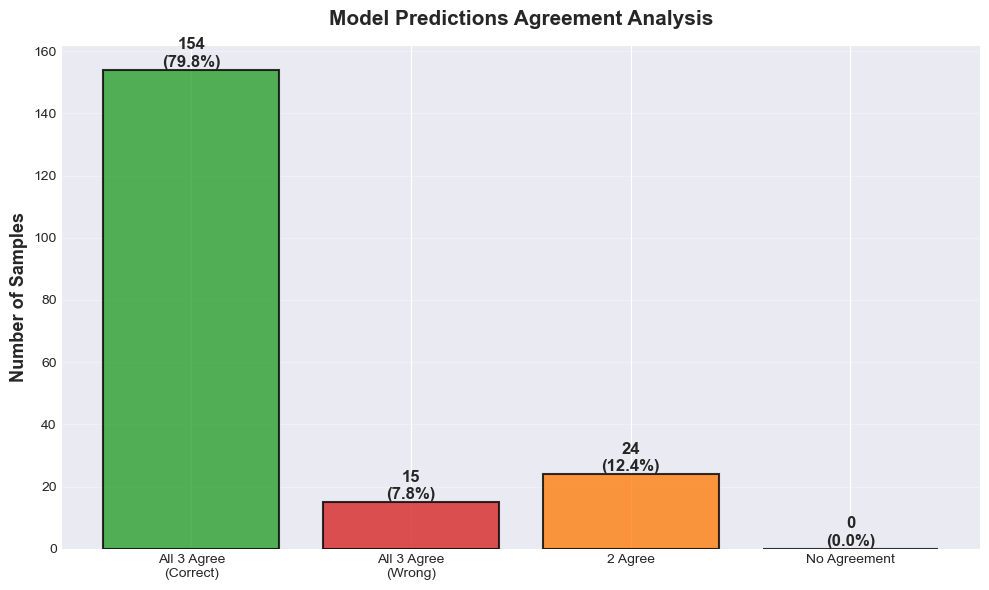

In [11]:
print("\n🤝 Analyzing model agreement...\n")

if len(models) == 3:
    # Get predictions
    pred_1 = results['spatial_cnn']['y_pred']
    pred_2 = results['multiscale_cnn']['y_pred']
    pred_3 = results['shallow_unet']['y_pred']
    y_true = results['spatial_cnn']['y_true']
    
    # Count agreements
    all_agree = (pred_1 == pred_2) & (pred_2 == pred_3)
    two_agree = ((pred_1 == pred_2) | (pred_2 == pred_3) | (pred_1 == pred_3)) & ~all_agree
    none_agree = ~all_agree & ~two_agree
    
    # Among all agreements, how many are correct?
    all_agree_correct = all_agree & (pred_1 == y_true)
    
    print(f"Agreement Analysis:")
    print(f"  All 3 models agree:      {all_agree.sum():4d} samples ({100*all_agree.mean():.1f}%)")
    print(f"    └─ Correct:            {all_agree_correct.sum():4d} samples ({100*all_agree_correct.sum()/all_agree.sum():.1f}%)")
    print(f"  2 models agree:          {two_agree.sum():4d} samples ({100*two_agree.mean():.1f}%)")
    print(f"  No agreement:            {none_agree.sum():4d} samples ({100*none_agree.mean():.1f}%)")
    
    # Visualize agreement
    fig, ax = plt.subplots(figsize=(10, 6))
    
    categories = ['All 3 Agree\n(Correct)', 'All 3 Agree\n(Wrong)', '2 Agree', 'No Agreement']
    counts = [
        all_agree_correct.sum(),
        all_agree.sum() - all_agree_correct.sum(),
        two_agree.sum(),
        none_agree.sum()
    ]
    colors = ['#2ca02c', '#d62728', '#ff7f0e', '#9467bd']
    
    bars = ax.bar(categories, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add count labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{count}\n({100*count/len(y_true):.1f}%)',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax.set_ylabel('Number of Samples', fontsize=13, fontweight='bold')
    ax.set_title('Model Predictions Agreement Analysis', fontsize=15, fontweight='bold', pad=15)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    save_path = FIGURES_DIR / 'model_agreement_analysis.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n✅ Saved: {save_path}")
    plt.show()
else:
    print("⚠️ Need all 3 models for agreement analysis")

## 12. Summary Report

In [12]:
print("\n" + "="*80)
print("EVALUATION SUMMARY")
print("="*80)

print("\n✅ Completed Tasks:")
print("  1. Loaded test dataset")
print("  2. Loaded trained model checkpoints")
print("  3. Evaluated all models on test set")
print("  4. Calculated performance metrics")
print("  5. Generated confusion matrices")
print("  6. Plotted ROC curves")
print("  7. Visualized sample predictions")
print("  8. Analyzed model agreement")

print("\n📊 Key Findings:")
print("\nBest Model by Metric:")
for model_key in models.keys():
    y_true = results[model_key]['y_true']
    y_pred = results[model_key]['y_pred']
    y_proba = results[model_key]['y_proba']
    
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_proba)
    
    print(f"  {MODEL_INFO[model_key]['name']}:")
    print(f"    Accuracy: {acc*100:.2f}% | F1: {f1*100:.2f}% | AUC: {auc_score:.4f}")

print("\n📁 Output Files:")
print(f"  Metrics:    {OUTPUTS_DIR / 'test_metrics.csv'}")
print(f"  Figures:    {FIGURES_DIR}")
print(f"    - Confusion matrices")
print(f"    - ROC curves")
print(f"    - Sample predictions")
print(f"    - Agreement analysis")

print("\n🎯 Recommendations:")
# Find best model by F1-score
best_f1 = 0
best_model = None
for model_key in models.keys():
    y_true = results[model_key]['y_true']
    y_pred = results[model_key]['y_pred']
    f1 = f1_score(y_true, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_model = model_key

if best_model:
    print(f"  🏆 Best overall model: {MODEL_INFO[best_model]['name']}")
    print(f"     (F1-Score: {best_f1*100:.2f}%)")
    print(f"\n  💡 Use {MODEL_INFO[best_model]['name']} for production inference")
    print(f"  💡 Consider ensemble of all 3 models for critical applications")

print("\n🚀 Next Steps:")
print("  1. ✅ Models evaluated on test set")
print("  2. ⬜ Apply best model to full study area")
print("  3. ⬜ Generate deforestation probability maps")
print("  4. ⬜ Calculate deforestation area statistics")
print("  5. ⬜ Create final report and visualizations")

print("\n" + "="*80)


EVALUATION SUMMARY

✅ Completed Tasks:
  1. Loaded test dataset
  2. Loaded trained model checkpoints
  3. Evaluated all models on test set
  4. Calculated performance metrics
  5. Generated confusion matrices
  6. Plotted ROC curves
  7. Visualized sample predictions
  8. Analyzed model agreement

📊 Key Findings:

Best Model by Metric:
  Spatial Context CNN:
    Accuracy: 85.49% | F1: 84.27% | AUC: 0.9265
  Multi-Scale CNN:
    Accuracy: 83.42% | F1: 81.82% | AUC: 0.9277
  Shallow U-Net:
    Accuracy: 89.64% | F1: 89.25% | AUC: 0.9605

📁 Output Files:
  Metrics:    ..\outputs\test_metrics.csv
  Figures:    ..\figures
    - Confusion matrices
    - ROC curves
    - Sample predictions
    - Agreement analysis

🎯 Recommendations:
  🏆 Best overall model: Shallow U-Net
     (F1-Score: 89.25%)

  💡 Use Shallow U-Net for production inference
  💡 Consider ensemble of all 3 models for critical applications

🚀 Next Steps:
  1. ✅ Models evaluated on test set
  2. ⬜ Apply best model to full stud